# second version, cleaner

RandomForest on raw features
Train accuracy: 1.000
CV accuracy:    0.625 ± 0.415

Feature importances:
                                          importance
PVP (% w/w)                                 0.245903
Metallic silver (%w/w)                      0.233913
Polydispersity index                        0.182254
Average diameter of  metallic cores (nm)    0.097422
Size distribution (nm)                      0.094924
Zeta potential                              0.079237
Hydrodynamic diameter                       0.066347


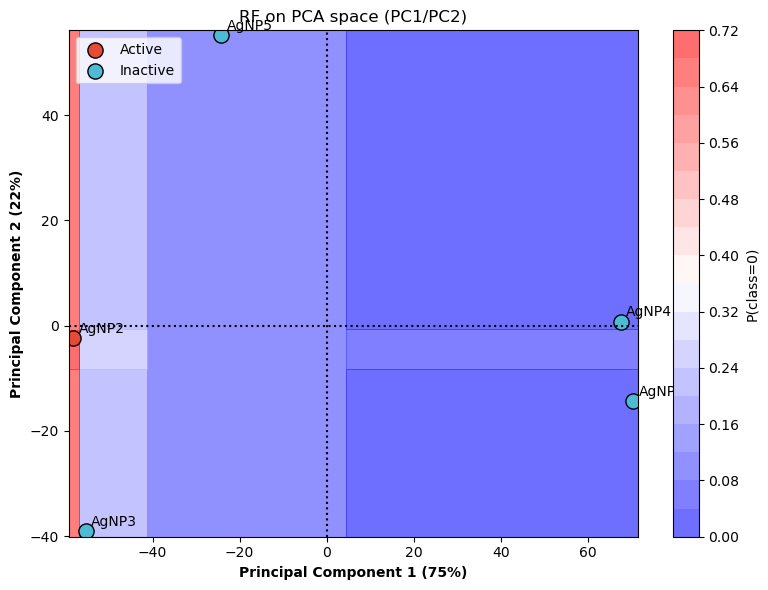

In [1]:
# Same results 
from __future__ import annotations
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from dataclasses import dataclass
import itertools
import numpy as np
import pandas as pd
from typing import Tuple, Dict, List

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# -----------------------
# Config
# -----------------------
DATA_DIR = Path("../data")
EXCEL_PATH = DATA_DIR / "datos nanoparticulas ML.xlsx"
EXCEL_SHEET = "Hoja2"

FEATURE_COLS = [
    "Average diameter of  metallic cores (nm)",
    "Size distribution (nm)",
    "Hydrodynamic diameter ",
    "Polydispersity index",
    "Zeta potential",
    "Metallic silver (%w/w)",
    "PVP (% w/w) ",
]

BIO_COLS_ACTIVE_FLAGS = [
    "Glucosidase (μg/ml).1",
    "Amilase (μg/ml).1",
    "DPPIV (μg/ml).1",
    "AGEs (μg/ml).1",
]

BIO_COLS_BASE = [
    "Glucosidase (μg/ml)",
    "Amilase (μg/ml)",
    "DPPIV (μg/ml)",
    "AGEs (μg/ml)",
]

PCA_CSV = DATA_DIR / "df_pca_PC_two.csv"   # must contain 'PC1', 'PC2' indexed by nanoparticle name
PCA_EXPLAINED = np.array([0.75129733, 0.21710735])  # PC1, PC2 explained variance (fractions)


# -----------------------
# Utilities
# -----------------------
def load_excel_frame(path: Path, sheet: str) -> pd.DataFrame:
    """Load Excel sheet and set nanoparticle names as index. Drops the first row like your original."""
    xlsx = pd.ExcelFile(path)
    if sheet not in xlsx.sheet_names:
        raise ValueError(f"Sheet '{sheet}' not found. Available: {xlsx.sheet_names}")

    df = xlsx.parse(sheet)
    # Drop the first row (your original code drops row 0)
    df = df.drop(index=df.index[0]).reset_index(drop=True)

    # Expect column "Nanoparticles" to exist
    if "Nanoparticles" not in df.columns:
        raise ValueError("Expected column 'Nanoparticles' not found in Excel data.")

    df = df.set_index("Nanoparticles")
    return df


def build_activity_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    From BIO_COLS_ACTIVE_FLAGS with 'activo' strings, build 0/1 columns
    prefixed with 'a_' aligned to BIO_COLS_BASE.
    """
    if len(BIO_COLS_ACTIVE_FLAGS) != len(BIO_COLS_BASE):
        raise ValueError("BIO_COLS_ACTIVE_FLAGS and BIO_COLS_BASE must be the same length.")

    out = df.copy()
    for col_flag, col_base in zip(BIO_COLS_ACTIVE_FLAGS, BIO_COLS_BASE):
        if col_flag not in out.columns:
            raise ValueError(f"Missing column '{col_flag}' to derive activity flags.")
        new_col = "a_" + col_base
        out[new_col] = (out[col_flag].astype(str).str.strip().str.lower() == "activo").astype(int)
    return out


def _name_from_bits(bits: Tuple[int, int, int, int]) -> str:
    labels = ["Glucosidase", "Amilase", "DPPIV", "AGEs"]
    chosen = [lab for bit, lab in zip(bits, labels) if bit == 1]
    if len(chosen) == 4:
        return "All"
    if len(chosen) == 0:
        return "None"
    return "_".join(chosen)


def build_multilabel_classes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Using the 'a_' columns, create:
      - Bioactivity_class_number: integer in [0..15] (all 4-bit combinations)
      - Bioactivity_class_name: "All"/"None"/"X_Y_..."
      - Bioactivity_class_number2 / name2: binary 'active' if >=3 actives or All; else 'inactive'
    """
    needed = [f"a_{c}" for c in BIO_COLS_BASE]
    for c in needed:
        if c not in df.columns:
            raise ValueError(f"Missing activity column '{c}'.")

    out = df.copy()

    # Number & name from 4-bit tuple
    bits_mat = out[needed].astype(int).values
    # Map tuple -> (number, name)
    mapping_number: Dict[Tuple[int, ...], int] = {}
    mapping_name: Dict[Tuple[int, ...], str] = {}
    for i, key in enumerate(itertools.product([0, 1], repeat=4)):
        mapping_number[key] = i
        mapping_name[key] = _name_from_bits(key)

    tuples = [tuple(row) for row in bits_mat]
    out["Bioactivity_class_number"] = [mapping_number[t] for t in tuples]
    out["Bioactivity_class_name"] = [mapping_name[t] for t in tuples]

    # Binary collapse: active if All OR at least 3 active markers
    counts = out[needed].sum(axis=1)
    out["Bioactivity_class_number2"] = np.where((out["Bioactivity_class_name"] == "All") | (counts >= 3), 1, 0)
    out["Bioactivity_class_name2"] = np.where(out["Bioactivity_class_number2"] == 1, "active", "inactive")

    return out


def select_features(df: pd.DataFrame, feature_cols: List[str]) -> pd.DataFrame:
    missing = [c for c in feature_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing feature columns: {missing}")
    return df[feature_cols].copy()


def evaluate_random_forest(
    X: pd.DataFrame,
    y: pd.Series,
    n_splits: int = 4,
    random_state: int = 42,
    n_estimators: int = 200,
    max_depth: int | None = 5,
    max_features: int | str | float | None = "sqrt",
) -> Tuple[RandomForestClassifier, float, float, float]:
    """
    Fit & CV a RandomForest on the whole X,y (small dataset case).
    Returns (model, train_acc, cv_mean, cv_std)
    """
    # NB: For classification use StratifiedKFold to keep class balance per fold
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        random_state=random_state,
        n_jobs=-1,
    )
    model.fit(X, y)

    cv_scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
    train_acc = model.score(X, y)
    return model, float(train_acc), float(cv_scores.mean()), float(cv_scores.std())


def feature_importance(model: RandomForestClassifier, X: pd.DataFrame) -> pd.Series:
    fi = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    return fi


def read_pca_frame(pca_csv: Path) -> pd.DataFrame:
    if not pca_csv.exists():
        raise FileNotFoundError(f"PCA CSV not found: {pca_csv}")
    dfp = pd.read_csv(pca_csv, index_col=0)
    for c in ("PC1", "PC2"):
        if c not in dfp.columns:
            raise ValueError("PCA CSV must contain 'PC1' and 'PC2' columns.")
    return dfp


def plot_pca_decision_surface(
    df_pca: pd.DataFrame,
    y_labels: pd.Series,
    explained: np.ndarray,
    out_prefix: str = "all_rf_model_two",
    random_state: int = 42,
):
    """
    Train RF on (PC1, PC2) and plot decision surface + points + annotations.
    Saves PNG and PDF side-by-side.
    """
    X = df_pca[["PC1", "PC2"]].copy()
    y = y_labels.astype("category").cat.codes

    model, train_acc, cv_mean, cv_std = evaluate_random_forest(
        X, y, n_splits=4, random_state=random_state, n_estimators=200, max_depth=5, max_features=2
    )

    # Grid
    pad = 1.0
    x1_min, x1_max = X["PC1"].min() - pad, X["PC1"].max() + pad
    x2_min, x2_max = X["PC2"].min() - pad, X["PC2"].max() + pad
    gx, gy = np.meshgrid(
        np.arange(x1_min, x1_max, 0.1),
        np.arange(x2_min, x2_max, 0.1),
    )
    grid = np.c_[gx.ravel(), gy.ravel()]
    proba = model.predict_proba(grid)[:, 0].reshape(gx.shape)

    # Split by label name for coloring
    name_series = df_pca["Bioactivity_class_name2"]
    label_active = df_pca[name_series == "active"]
    label_inactive = df_pca[name_series == "inactive"]

    fig, ax = plt.subplots(figsize=(8, 6))
    cf = ax.contourf(gx, gy, proba, levels=20, cmap="bwr", alpha=0.6)
    fig.colorbar(cf, ax=ax, label="P(class=0)")

    ax.scatter(label_active["PC1"], label_active["PC2"], s=120, label="Active", c="#E64B35", edgecolors="black")
    ax.scatter(label_inactive["PC1"], label_inactive["PC2"], s=120, label="Inactive", c="#4DBBD5", edgecolors="black")

    # Annotate each point with index (nanoparticle name)
    for name, row in df_pca.iterrows():
        ax.annotate(str(name), (row["PC1"], row["PC2"]), fontsize=10, color="#000000", xytext=(4, 4), textcoords="offset points")

    ax.axvline(0, c="black", ls=":")
    ax.axhline(0, c="black", ls=":")
    ax.set_xlabel(f"Principal Component 1 ({explained[0]*100:.0f}%)", fontweight="bold")
    ax.set_ylabel(f"Principal Component 2 ({explained[1]*100:.0f}%)", fontweight="bold")
    ax.legend(loc="upper left", frameon=True)
    ax.set_title("RF on PCA space (PC1/PC2)")

    fig.tight_layout()
    fig.savefig(f"{out_prefix}.png", dpi=500, bbox_inches="tight")
    fig.savefig(f"{out_prefix}.pdf", dpi=500, bbox_inches="tight")
    plt.show()

# -----------------------
# Main flow (runs in notebook or as script)
# -----------------------
def main() -> None:
    # 1) Load and prep
    df = load_excel_frame(EXCEL_PATH, EXCEL_SHEET)
    df = build_activity_columns(df)
    df = build_multilabel_classes(df)

    # 2) Supervised target (binary: active vs inactive)
    y_name2 = df["Bioactivity_class_name2"]
    y_codes = y_name2.astype("category").cat.codes

    # 3) Features
    X = select_features(df, FEATURE_COLS)

    # 4) RF evaluation
    model, train_acc, cv_mean, cv_std = evaluate_random_forest(
        X, y_codes, n_splits=4, random_state=42, n_estimators=200, max_depth=5, max_features=2
    )

    print("===================================")
    print("RandomForest on raw features")
    print(f"Train accuracy: {train_acc:.3f}")
    print(f"CV accuracy:    {cv_mean:.3f} ± {cv_std:.3f}")
    print("===================================")

    # 5) Feature importances
    fi = feature_importance(model, X)
    print("\nFeature importances:")
    print(fi.to_frame("importance"))

    # 6) Persist the labeled frame (like your pickle)
    df.to_pickle("Bioactivity_class_name2_two_2.pkl")

    # 7) Optional: PCA decision surface if file exists
    if PCA_CSV.exists():
        df_pca = read_pca_frame(PCA_CSV)
        # attach labels for plotting/annotation
        df_pca = df_pca.join(df[["Bioactivity_class_name2"]], how="left")
        plot_pca_decision_surface(df_pca, y_name2, PCA_EXPLAINED, out_prefix="all_rf_model_two")
    else:
        print(f"[Info] Skipping PCA plot because '{PCA_CSV}' was not found.")


if __name__ == "__main__":
    main()
